<a href="https://colab.research.google.com/github/hussienalbared/Cudalab/blob/main/assignment3_experiment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import os

import torch

import torch.nn as nn
from tqdm import tqdm
from torch import Tensor
from torch.utils.data import DataLoader, Dataset, ConcatDataset
from torchvision import transforms as tf, models, datasets

from torch.utils.tensorboard import SummaryWriter
import shutil

writer = SummaryWriter()



In [ ]:
alpha=0.2

In [2]:
from google.colab import drive
mount_point="/content/drive2/"
drive.mount(mount_point)

Mounted at /content/drive2/


In [ ]:
TBOARD_LOGS = os.path.join(mount_point+"MyDrive", "tboard_logs", "test")
if not os.path.exists(TBOARD_LOGS):
    os.makedirs(TBOARD_LOGS)
shutil.rmtree(TBOARD_LOGS)
writer = SummaryWriter(TBOARD_LOGS)    

In [ ]:
#!unzip   mount_point+'My Drive/colab_unzip/dataset.zip' -d mount_point+'My Drive/colab_unzip'
# 

In [ ]:
def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
   
    index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [3]:
dataset_path=f'{mount_point}My Drive/colab_unzip/dataset/'
dataset_path

'/content/drive2/My Drive/colab_unzip/dataset'

In [ ]:
data_transforms = {
    'train': tf.Compose([
        tf.RandomResizedCrop(224),
        tf.RandomHorizontalFlip(),
        tf.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        tf.ToTensor(),
        tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': tf.Compose([
        tf.Resize(256),
        tf.CenterCrop(224),
        tf.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3),
        tf.ToTensor(),
        tf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = datasets.ImageFolder(f'{dataset_path}train', data_transforms["train"])
test_dataset = datasets.ImageFolder(f'{dataset_path}test', data_transforms["test"])

N_train = len(train_dataset)
N_test = len(test_dataset)
print(f"Training set size: {N_train} images")
print(f"Test set size: {N_test} images")

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)



class_names = train_dataset.classes


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, train_loader, optimizer, criterion, epoch, device):
    """ Training a model for one epoch """
    
    loss_list = []
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        images, targets_a, targets_b, lam = mixup_data(images, labels,
                                                       alpha)
        
        
        
        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()
         
        # Forward pass to get output/logits
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
         
        # Calculate Loss: softmax --> cross entropy loss
        #loss = criterion(outputs, labels)
        loss_list.append(loss.item())
         
        # Getting gradients w.r.t. parameters
        loss.backward()
         
        # Updating parameters
        optimizer.step()
        
    mean_loss = np.mean(loss_list)
    return mean_loss, loss_list


@torch.no_grad()
def eval_model(model, test_loader, criterion, device):
    """ Evaluating the model for test """
    correct = 0
    total = 0
    loss_list = []
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass only to get logits/output
        outputs = model(images)
                 
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())
            
        # Get predictions from the maximum value
        preds = torch.argmax(outputs, dim=1)
        correct += len( torch.where(preds==labels)[0] )
        total += len(labels)
                 
    # Total correct predictions and loss
    accuracy = correct / total * 100
    loss = np.mean(loss_list)
    
    return accuracy, loss


def train_model(model, optimizer, scheduler, criterion, train_loader, valid_loader, num_epochs, tboard=None, start_epoch=0):
    """ Training a model for a given number of epochs"""
    
    train_loss = []
    val_loss =  []
    loss_iters = []
    valid_acc = []
    
    for epoch in range(num_epochs):
           
        # validation epoch
        model.eval()  # important for dropout and batch norms
        accuracy, loss = eval_model(
                    model=model, test_loader=valid_loader,
                    criterion=criterion, device=device
            )
        valid_acc.append(accuracy)
        val_loss.append(loss)
        writer.add_scalar(f'Accuracy/Valid', accuracy, global_step=epoch+start_epoch)
        writer.add_scalar(f'Loss/Valid', loss, global_step=epoch+start_epoch)
        
        # training epoch
        model.train()  # important for dropout and batch norms
        mean_loss, cur_loss_iters = train_epoch(
                model=model, train_loader=train_loader, optimizer=optimizer,
                criterion=criterion, epoch=epoch, device=device
            )
        scheduler.step()
        train_loss.append(mean_loss)
        writer.add_scalar(f'Loss/Train', mean_loss, global_step=epoch+start_epoch)

        loss_iters = loss_iters + cur_loss_iters
        
        if(epoch % 5 == 0 or epoch==num_epochs-1):
            print(f"Epoch {epoch+1}/{num_epochs}")
            print(f"    Train loss: {round(mean_loss, 5)}")
            print(f"    Valid loss: {round(loss, 5)}")
            print(f"    Accuracy: {accuracy}%")
            print("\n")
    
    print(f"Training completed")
    return train_loss, val_loss, loss_iters, valid_acc

def smooth(f, K=5):
    """ Smoothing a function using a low-pass filter (mean) of size K """
    kernel = np.ones(K) / K
    f = np.concatenate([f[:int(K//2)], f, f[int(-K//2):]])  # to account for boundaries
    smooth_f = np.convolve(f, kernel, mode="same")
    smooth_f = smooth_f[K//2: -K//2]  # removing boundary-fixes
    return smooth_f

def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

set_random_seed()




Training set size: 1400 images
Test set size: 599 images
['cats', 'dogs']


In [ ]:
ResNetFineTuned = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_nuerons = ResNetFineTuned.fc.in_features
ResNetFineTuned.fc = nn.Linear(num_nuerons, 2)
ResNetFineTuned = ResNetFineTuned.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 340MB/s]


In [ ]:
def draw_plots(loss_iters,train_loss,val_loss,valid_acc):
  plt.style.use('seaborn-v0_8')
  fig, ax = plt.subplots(1,3)
  fig.set_size_inches(24,5)

  smooth_loss = smooth(loss_iters, 31)
  ax[0].plot(loss_iters, c="blue", label="Loss", linewidth=3, alpha=0.5)
  ax[0].plot(smooth_loss, c="red", label="Smoothed Loss", linewidth=3, alpha=1)
  ax[0].legend(loc="best")
  ax[0].set_xlabel("Iteration")
  ax[0].set_ylabel("CE Loss")
  ax[0].set_title("Training Progress")

  epochs = np.arange(len(train_loss)) + 1
  ax[1].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
  ax[1].plot(epochs, val_loss, c="blue", label="Valid Loss", linewidth=3)
  ax[1].legend(loc="best")
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("CE Loss")
  ax[1].set_title("Loss Curves")

  epochs = np.arange(len(val_loss)) + 1
  ax[2].plot(epochs, valid_acc, c="red", label="Valid accuracy", linewidth=3)
  ax[2].legend(loc="best")
  ax[2].set_xlabel("Epochs")
  ax[2].set_ylabel("Accuracy (%)")
  ax[2].set_title(f"Valdiation Accuracy (max={round(np.max(valid_acc),2)}% @ epoch {np.argmax(valid_acc)+1})")

  plt.show()

In [ ]:

def train_pretraind_model(model,model_name,num_epochs,optimizer=None):
    
    criterion = nn.CrossEntropyLoss()
    if not optimizer:
     optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
    # Observe that all parameters are being optimized
    

    # Decay LR by a factor of 0.1 every 7 epochs
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    TBOARD_LOGS = os.path.join(mount_point+"MyDrive", "tboard_logs", model_name)
    if not os.path.exists(TBOARD_LOGS):
        os.makedirs(TBOARD_LOGS)

    shutil.rmtree(TBOARD_LOGS)
    writer = SummaryWriter(TBOARD_LOGS)
    train_loss, val_loss, loss_iters, valid_acc = train_model(
            model=model, optimizer=optimizer, scheduler=scheduler, criterion=criterion,
            train_loader=train_loader, valid_loader=test_loader, num_epochs=num_epochs,tboard=writer
        )
   
    return train_loss, val_loss, loss_iters, valid_acc
    

## Compare the following: Fine-Tuned ResNet, ResNet as fixed feature extractor, and ResNet with a Combined Approach

Epoch 1/6
    Train loss: 0.33593
    Valid loss: 0.85148
    Accuracy: 40.73455759599332%


Epoch 6/6
    Train loss: 0.25256
    Valid loss: 0.12817
    Accuracy: 97.66277128547578%


Training completed


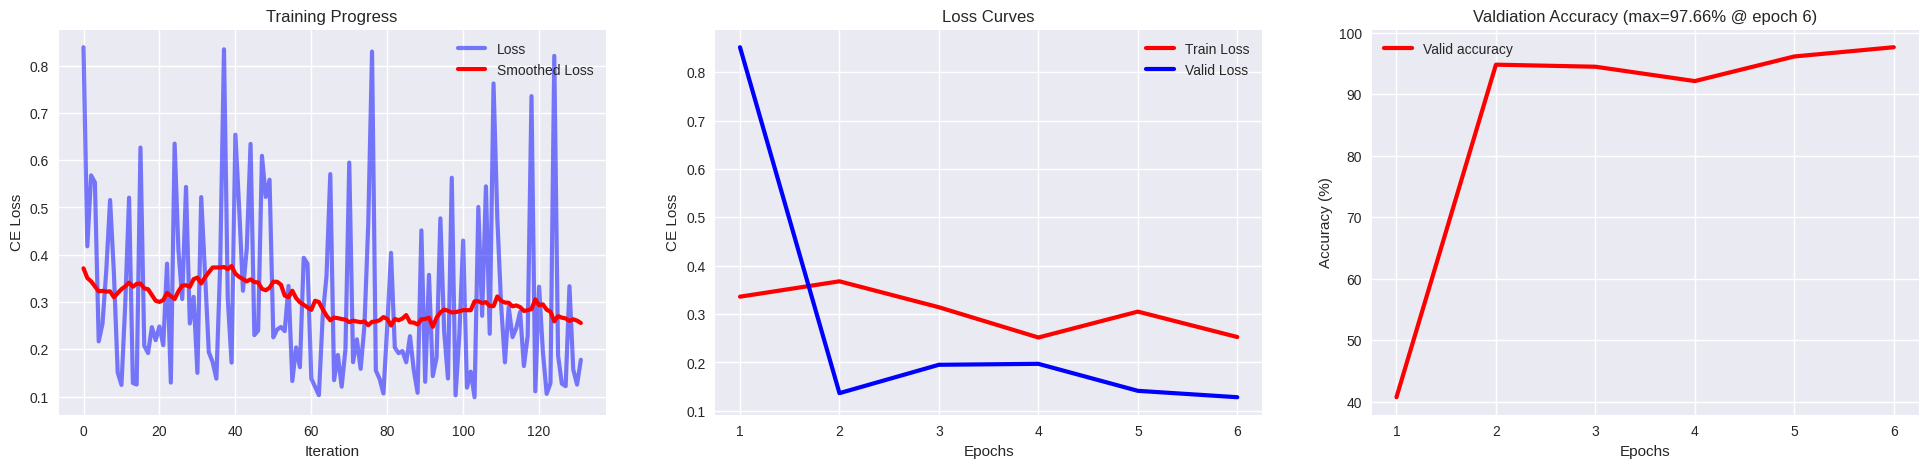

In [ ]:

train_loss, val_loss, loss_iters, valid_acc =train_pretraind_model(ResNetFineTuned,model_name="ResNetFineTuned",num_epochs=20)
draw_plots(loss_iters=loss_iters,train_loss=train_loss,val_loss=val_loss,valid_acc=valid_acc)

### ResNet as fixed feature extractor

Epoch 1/6
    Train loss: 0.62996
    Valid loss: 0.73224
    Accuracy: 51.25208681135225%


Epoch 6/6
    Train loss: 0.36384
    Valid loss: 0.22369
    Accuracy: 95.99332220367279%


Training completed


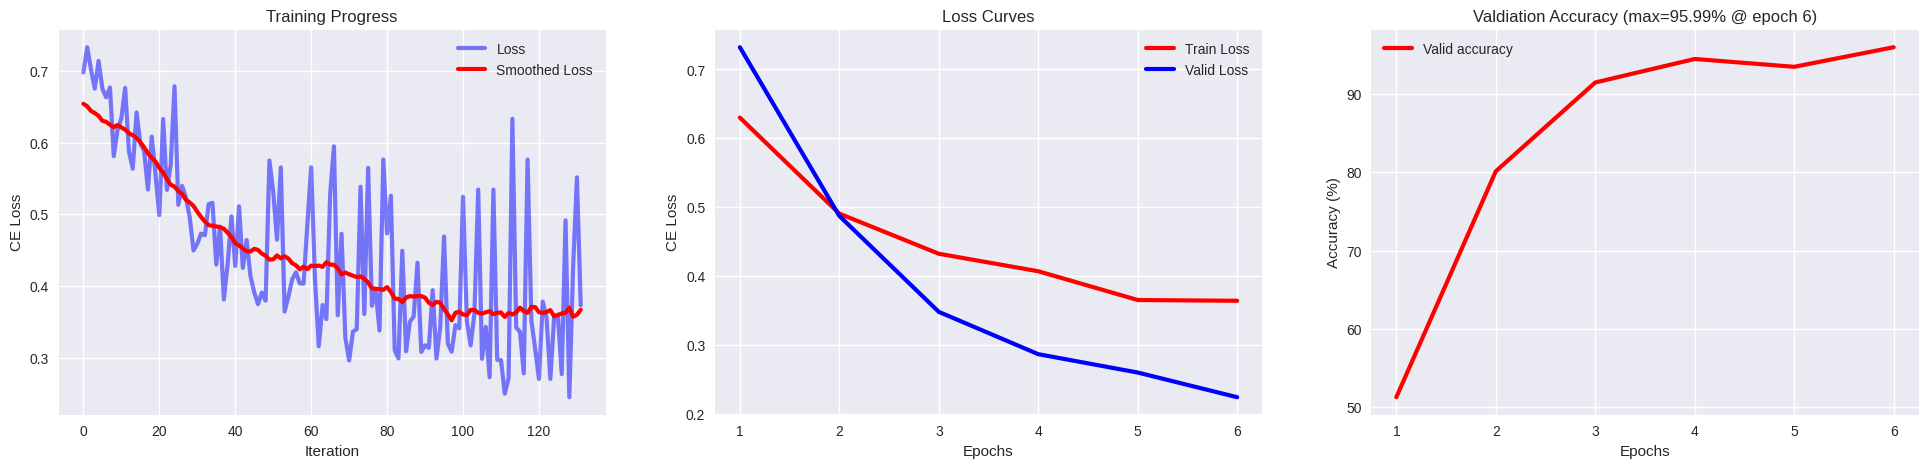

In [ ]:
fixedModelresnet=models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in fixedModelresnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_logits = fixedModelresnet.fc.in_features
fixedModelresnet.fc = nn.Linear(num_logits, 2)
fixedModel = fixedModelresnet.to(device)
train_loss, val_loss, loss_iters, valid_acc =train_pretraind_model(fixedModelresnet,model_name="fixedModelresnet",num_epochs=20)
draw_plots(loss_iters=loss_iters,train_loss=train_loss,val_loss=val_loss,valid_acc=valid_acc)


### ResNet with a Combined Approach

In [ ]:
set_random_seed()

combinedresnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) #pretrained=True

# Freezing model parameters
for param in fixedModelresnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_logits = combinedresnet.fc.in_features
combinedresnet.fc = nn.Linear(num_logits, 2)
combinedresnet = combinedresnet.to(device)
train_loss, val_loss, loss_iters, valid_acc =train_pretraind_model(combinedresnet,"CombinedApproachModelresnet",num_epochs=10)



# Unfreezing model parameters
for param in combinedresnet.parameters():
    param.requires_grad = True


optimizer = torch.optim.Adam(combinedresnet.parameters(), lr=3e-4)
# Lowering learning rate
for g in optimizer.param_groups:
    g['lr'] *= 0.1

next_train_loss, next_val_loss, next_loss_iters, next_valid_acc =train_pretraind_model(combinedresnet,"CombinedApproachModelresnet",num_epochs=10,optimizer=optimizer)
concat_train_loss = train_loss + next_train_loss
concat_val_loss = val_loss + next_val_loss
concat_loss_iters = loss_iters + next_loss_iters
concat_valid_acc = valid_acc + next_valid_acc
draw_plots(loss_iters=concat_loss_iters,train_loss=concat_train_loss,val_loss=concat_val_loss,valid_acc=concat_valid_acc)


Epoch 1/6
    Train loss: 0.68084
    Valid loss: 0.85148
    Accuracy: 40.73455759599332%




#### Comparison between finetund resnet, feature extactor resnet,combined apparoach resnet

From the plot above the first difference between the three models IN the training, progress is approximately no difference between the combined approach and feature extractor approach and they are more smooth than the finetuned model.
With respect to the loss curve, the feature extractor approach and the combined approach are similar with a small margin between the train loss and valid loss while in finetuned the model shows a fluctuation in both train and test loss.
The same has happened with respect to validation accuracy the fine-tuned show some fluctuation in the latest epochs. 
In general the accuacy of the feature extractor  appraoch  anf the combined appraoch are approximitly the same with a small margin but the fine-tuned approach is the best in term of accuracy with a big marigin.

In [ ]:
%load_ext tensorboard
# %tensorboard --logdir logs
%tensorboard --logdir "/content/drive2/MyDrive/tboard_logs"